# Question 6: Train your agent with the replay buffer
A replay buffer of size 2000 was used to store values and batch learn online

# Running this file
Run the until stopped and proceed as instucted


In [1]:
import sys
import math
import random
import pdb
import numpy as np
import tensorflow as tf
import gym
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib
import os
from copy import deepcopy
warnings.filterwarnings('ignore')

In [2]:
# create a network that  will be used to take the loss.
def get_q_optimize2(state, next_state,action, alpha, reward, discount = 0.99):

    weights = {'w1': tf.Variable(tf.random_uniform([4, 100], 0, 0.01)),
               'w2': tf.Variable(tf.random_uniform([100, 2], 0, 0.01))}
    biases = {'b1': tf.Variable(tf.random_uniform([100], 0, 0.01)),
              'b2': tf.Variable(tf.random_uniform([2], 0, 0.01))}

    hidden = tf.nn.relu(tf.matmul(state, weights['w1']) + biases['b1'])
    q = tf.matmul(hidden, weights['w2']) + biases['b2']

    hidden = tf.nn.relu(tf.matmul(next_state, weights['w1']) + biases['b1'])
    q_prime = tf.matmul(hidden, weights['w2']) + biases['b2']


    delta = reward + 1   # don't boostrap if state is terminal
    q_prime_max = tf.reshape(tf.reduce_max(q_prime, reduction_indices=[1]), [-1, 1])
    qa = tf.reshape(tf.gather_nd(q, action), [-1, 1])
    diff = tf.square(reward + discount * tf.multiply(delta, tf.stop_gradient(q_prime_max)) - qa) / 2
    loss = tf.reduce_mean(diff)

    opt = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return opt, q, loss

In [3]:
# Training parameters
max_eps_length = 300
discount = 0.99
alpha = 0.001
n_episodes = 2000
freq = n_episodes/100
epsilon = 0.05
sample_episodes = 10
episode_lengths = []
episode_returns = []

In [4]:
def eps_greed(q,counting,epsilon=0.05):
    u = np.random.uniform(0,1,1)
    if u <= epsilon:
        counting+=1

        if np.random.uniform(0,1,1)>0.5:
            act = 0
        else:
            act = 1
    else:
        act = np.argmax(q)
        
    return act, counting

# Do not run these cells...
Continue to load data below to load model and get return and length of episodes

### Initialize buffer
First need to initialize buffer with tuples of (s,a,r,s')

In [5]:
episode_data = []
env = gym.make('CartPole-v0')
for i_episode in range(2000):
        discount = 0.99
        episode_return = 0
        episode_length = 0
        s = env.reset()

        for t in range(300):
            discount_t = discount ** t
            #env.render()
            action = env.action_space.sample()  # 0 is hitting right of block, 1 is hitting left
            s_prime, reward, done, info = env.step(action)

            if done:
                # print("Episode finished after {} timesteps".format(t+1))
                episode_length = t + 1
                episode_return += (-1 * discount_t)  # -1 reward for terminating time-steps
                episode_data.append(np.append(np.append(s.reshape(1,-1), np.array([action, -1] ) ), np.zeros([1,4])))
                break
            else:
                episode_return += 0  # 0 reward for non-terminating time-steps
                episode_data.append(np.append(np.append(s.reshape(1,-1), np.array([action, 0])),s_prime.reshape(1,-1)))
            s = s_prime
episode_data = np.asarray(episode_data )

[2017-04-06 22:44:22,489] Making new env: CartPole-v0


In [8]:
filename = 'replay_buffer_data'
np.save(filename, episode_data)

In [5]:
b = np.load("./replay_buffer_data.npy") 

In [7]:
b.shape

(44094, 10)

In [6]:
# Need to save the model, weights and biases varibles

# Suggested Directory to use
save_MDir = 'new_models/A6/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

#save_model = os.path.join(save_MDir,'replay_model')

In [7]:
start = time.time()
replay_buffer = np.load("./replay_buffer_data.npy")
replay_buffer = replay_buffer[:5000,:]
batch_size = 64
sample_episodes = 15
n_episodes = 100
freq = n_episodes/100
count = 0
counting = 0    
replay_count = 0

episode_loss = []
total_episode_lengths = []
total_episode_returns = []
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state = tf.placeholder("float", [None, 4], name = 'state')
action = tf.placeholder(tf.int32, [None, 2], name = 'actions')
next_state = tf.placeholder("float", [None, 4], name = 'next_states')
reward = tf.placeholder("float", [None, 1], 'rewards')

optimize,q,loss = get_q_optimize2(state, next_state,action, alpha, reward, discount)

terminate_episode = False
init = tf.global_variables_initializer()
saver = tf.train.Saver()


with tf.Session() as sess:
    sess.run(init)

    for i_episode in range(n_episodes):
        if i_episode % freq == 0:
            print('Now runnning episode:{}'.format(i_episode))
            print('Total run time so far is: {}\n'.format(time.time()-start))
            if i_episode>0:
                print('last episode length {}'.format(np.mean(sample_episode_lengths)))
                if np.mean(sample_episode_lengths)>250:
                        print('Saving model...')
                        file_name = "A6_large%i.ckpt" %(int(alpha*100000))
                        save_model = os.path.join(save_MDir,file_name)
                        saver.save(sess= sess, save_path = save_model)
        # Every 10 episodes we take 10 sample runs and report their average lengths
        if i_episode % freq == 0:
            
            sample_episode_lengths = []
            sample_episode_returns = []            
            for _ in range(sample_episodes):
                s = env.reset()
                for t in range(max_eps_length):
                    cur_q = sess.run(q, feed_dict={state:s.reshape(1,-1)})
                    a, counting = eps_greed(cur_q,counting)
                    s_prime,re,done,info = env.step(a)
                    

                    if done:
                        #print('episode finished')
                        re = -1
                        sample_episode_lengths.append(t+1)
                        sample_episode_returns.append(-1*discount**t)
                        break

                    s = s_prime
            total_episode_lengths.append(np.mean(sample_episode_lengths))
            total_episode_returns.append(np.mean(sample_episode_returns))


        s = env.reset()
        for t in range(max_eps_length):
            cur_q = sess.run(q, feed_dict={state:s.reshape(1,-1)})
            a, counting = eps_greed(cur_q,counting)
            s_prime,re,done,info = env.step(a)
            
            if done:
                re = -1
                # replace buffer with updated s,a,r,s'
                replay_buffer[replay_count,:] = np.append(np.append(s.reshape(1,-1), np.asarray([a, re])), s_prime.reshape(1,-1))
                replay_count +=1
                if replay_count == replay_buffer.shape[0]:
                    replay_count =0
                episode_lengths.append(t+1)
                episode_returns.append(-1*discount**t)
                terminate_episode = True
                if i_episode % freq == 0:
                    print('For episode {} the length is: {}'.format( i_episode+1,t+1))
            else:
                re = 0
                
                # replace buffer with updated s,a,r,s'
                replay_buffer[replay_count,:] = np.append(np.append(s.reshape(1,-1), np.asarray([a, re])), s_prime.reshape(1,-1))
                replay_count +=1
                if replay_count == replay_buffer.shape[0]:
                    replay_count =0
            
            # Now I need to put in the batch. ie copy orig data shuffle, take first 64 samples, dont  fprget to label actinos
            # optimize and repeat
            #print(replay_count)
            shuffled_data = deepcopy(replay_buffer)
            np.random.shuffle(shuffled_data)
            batch = shuffled_data[:batch_size,:]
            #print(batch.shape[0])
            act = batch[:, 4].reshape(-1, 1)
            act = np.append(np.arange(len(act)).reshape(-1, 1), act, axis=1)
            this_dict = {state : batch[:,:4],action:act,
                         reward : batch[:,5].reshape(-1,1), next_state: batch[:,-4:]
                        }
            #this_dict = {state:s.reshape(-1,1), next_state:s_prime.reshape(-1,1), action:a, reward:re}
            opt, ls = sess.run([optimize,loss],this_dict)

            if  terminate_episode == True:
                count +=1
                terminate_episode = False
                break
            s = s_prime
            

        if i_episode %freq == 0:
                episode_loss.append(ls)
 
    print('Saving model...')
    saver.save(sess= sess, save_path = save_model)

total_episode_lengths = np.asarray(total_episode_lengths).reshape(-1,1)
total_episode_returns = np.asarray(total_episode_returns).reshape(-1,1)
episode_loss = np.asarray(episode_loss).reshape(-1,1)

saved_data  = np.concatenate((total_episode_lengths, total_episode_returns, episode_loss), axis=1)
filename = './results/A6_results.csv'
#np.savetxt(filename, saved_data, delimiter=' ,')
print('Total run time is: {}'.format(time.time()-start))

[2017-04-06 22:44:45,298] Making new env: CartPole-v0


Now runnning episode:0
Total run time so far is: 0.3681149482727051

For episode 1 the length is: 10
Now runnning episode:1
Total run time so far is: 0.4870879650115967

last episode length 9.333333333333334
For episode 2 the length is: 9
Now runnning episode:2
Total run time so far is: 0.5923738479614258

last episode length 9.2
For episode 3 the length is: 9
Now runnning episode:3
Total run time so far is: 0.7000851631164551

last episode length 9.6
For episode 4 the length is: 9
Now runnning episode:4
Total run time so far is: 0.804976224899292

last episode length 9.266666666666667
For episode 5 the length is: 12
Now runnning episode:5
Total run time so far is: 0.9358103275299072

last episode length 9.666666666666666
For episode 6 the length is: 12
Now runnning episode:6
Total run time so far is: 1.0731773376464844

last episode length 9.733333333333333
For episode 7 the length is: 71
Now runnning episode:7
Total run time so far is: 1.7591197490692139

last episode length 29.86666

KeyboardInterrupt: 

In [12]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


20.0


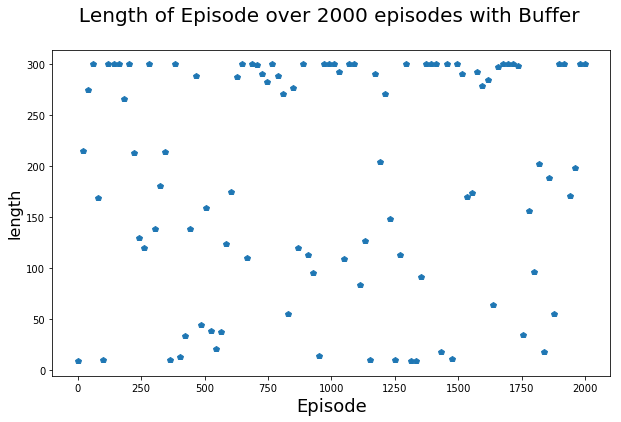

In [14]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,0],'p')# plotting t,a separately 

fig.suptitle('  Length of Episode over 2000 episodes with Buffer', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('length', fontsize=16)
plt.show()
fig.savefig('./results/pics/A6_lengths_p.jpg')

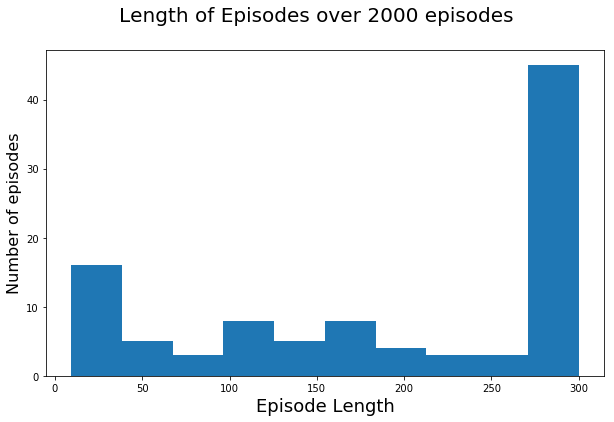

In [16]:
fig = plt.figure()
plt.hist(saved_data[:,0])
fig.suptitle('Length of Episodes over 2000 episodes', fontsize=20)
plt.xlabel('Episode Length', fontsize=18)
plt.ylabel('Number of episodes', fontsize=16)
plt.show()
fig.savefig('./results/pics/A6_length_hist.jpg')

20.0


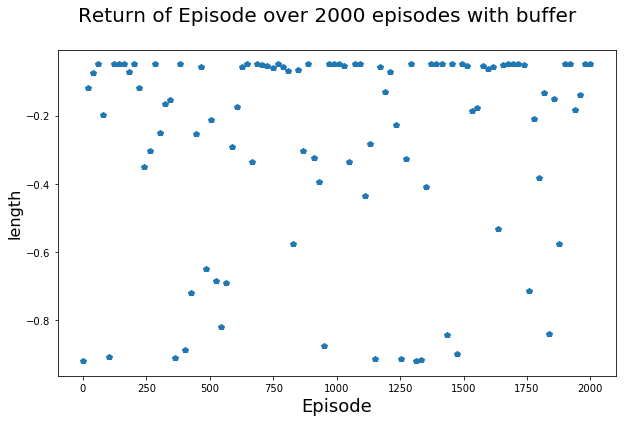

In [18]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,1],'p')# plotting t,a separately 

fig.suptitle('Return of Episode over 2000 episodes with buffer', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('length', fontsize=16)
plt.show()
fig.savefig('./results/pics/A6_returns_p.jpg')

20.0


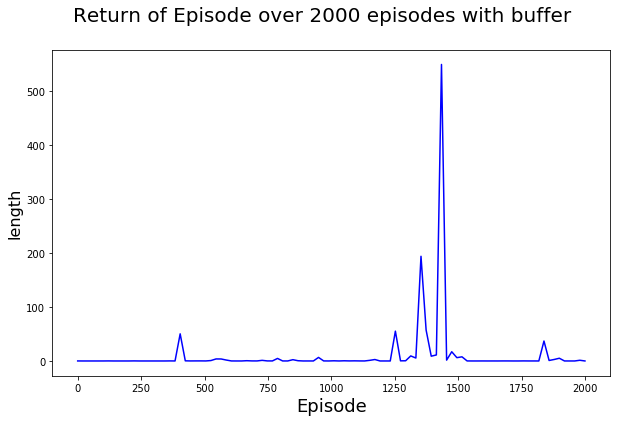

In [19]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,2],'b')# plotting t,a separately 

fig.suptitle('Return of Episode over 2000 episodes with buffer', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('length', fontsize=16)
plt.show()
fig.savefig('./results/pics/A6_loss.jpg')

# Load Model
Load the model of the best learning rate. Output the Average return and episode length

In [5]:
alpha = 0.001
file_name = "A6_large%i.ckpt" %(int(alpha*100000))
save_MDir = 'new_models/A6/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
print(save_model)

new_models/A6/A6_large100.ckpt


In [6]:
def test_epoch(sess, test_episodes):   
    e_length = []
    e_return = []
    av_len = []
    av_ret = []
    for _ in range(test_episodes):
        s = env.reset()
        
        for t in range(300):
            this_q = sess.run(q, feed_dict={state: s.reshape(1, 4)})
            #ac_greedily
            a = np.argmax(this_q)

            s_prime, rwd, done, info = env.step(a)

            if done:
                e_length.append(t+1)
                e_return.append(-1 * discount**t)
                break
            s = s_prime

    #av_len.append(np.mean(np.array(episode_length)))
    #av_ret.append(np.mean(np.array(episode_return)))
    return e_length, e_return

In [7]:
def get_placeholders():
    state = tf.placeholder("float", [None, 4])
    action = tf.placeholder(tf.int32, [None, 2])
    next_state = tf.placeholder("float", [None, 4])
    reward = tf.placeholder("float", [None, 1])
    return state, action, next_state, reward

In [8]:
tf.reset_default_graph()
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state, action, next_state, reward = get_placeholders()
optimize,q,loss = get_q_optimize2(state, next_state,action, alpha, reward, discount)
init  = tf.global_variables_initializer()
test_episodes = 50
"""---------------- restore model after training  --------------------------"""
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    print(save_model)
    saver.restore(sess = sess, save_path= save_model)
    print("Restored values for learning rate: ",alpha)
    restored_length, restored_return = test_epoch(sess,50)
    print('The average length of episode is: {} with std: {} '.format(np.mean(restored_length),np.std(restored_length)))
    print('The average return of episode is: {} with std: {} '.format(np.mean(restored_return),np.std(restored_return)))


[2017-04-08 14:28:40,675] Making new env: CartPole-v0


new_models/A6/A6_large100.ckpt
Restored values for learning rate:  0.001
The average length of episode is: 297.1 with std: 15.46124186474036 
The average return of episode is: -0.051855354429010916 with std: 0.01303608791662235 
